In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
from matplotlib import pyplot as plt
import math

In [2]:
df_z = pd.read_parquet('../../data/pre_processed/covid_cases_z_trans.parquet')

# Forecasting with GMM

This notebook was used to test GMM clusterinng in combination with forecasting. Note: not able to test all clusters with test countries Algeria, Bangladesh, Belgium and Croatia as both Algeria and Bangladesh reside in the same cluster.

In [3]:
#Function used to perform prediction. Input: forecasting model, traning dataframe, test dataframe, 
#list of features, and number of predictions, default 8. Returns dataframe with same format as
#additional test_df, with an additional column with predictions.

def predict(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    #Generating an encoder for country feature by converting country string to int value
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    #Dataframe with all features
    x_training_df = training_df[feature_list].copy()
    #Dataframe with all cases
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end and predict (10-10-2020->17-10-2020)
        features_df = test_df[feature_list][start_period:end_period].copy()
        #Generating an encoder for country feature by converting country string to int value
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    df_result = test_df.assign(Predicted=prediction_list)
    return df_result

In [4]:
#Function that computes a SMAPE. Input: dataframe including true and prediction,
#true_column that specifies which column of df holds the true values and 
#pred_column that specifies which column of df hold the predicted values
def SMAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()
    return 1/len(true_list)*np.sum(2*np.abs(pred_list-true_list)/(np.abs(true_list)+np.abs(pred_list))*100)

In [5]:
#Function computes an additional column which sums predicted value together to form an accumulated
#prediction. Prediction for day 0 is summed to the known total cases the day before.
#Input: dataframe contanint all data on test country and dataframe including predictions produced
#by def forecast. 
def accumulated_dataframe_column(df_test_country,CB_df):
    test_start_value = df_test_country.loc[df_test_country.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    accumulated_list = [math.floor(test_start_value+CB_df['Predicted'][0])]
    for i in range(1,len(CB_df)):
        accumulated_list.append(math.floor(accumulated_list[i-1]+CB_df['Predicted'][i]))
    df_result = CB_df.copy()
    df_result['Accumulated_Prediction'] = accumulated_list
    return df_result

## Creating cluster, GMM

In [6]:
gmm_z = GaussianMixture(4) #GMM with 4 clusters
gmm_z.fit(df_z.T)
labels_gmm_z = gmm_z.predict(df_z.T)

In [7]:
labels_gmm_z

array([0, 3, 3, 2, 0, 0, 1, 2, 0, 0, 1, 0, 3, 3, 3, 1, 3, 2, 0, 0, 2, 3,
       2, 2, 0, 3, 1, 2, 3, 3, 1, 3, 2, 3, 3, 0, 0, 0, 2, 0, 2, 3, 0, 3,
       3, 3, 3, 2, 0, 2, 0, 0, 0, 3, 0, 3, 0, 1, 3, 1, 3, 0, 0, 0, 3, 1,
       0, 3, 1, 1, 2, 2, 0, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3])

In [8]:
print("GMM:")
print("Countries in cluster 0:", np.count_nonzero(labels_gmm_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_gmm_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_gmm_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_gmm_z == 3))

GMM:
Countries in cluster 0: 26
Countries in cluster 1: 14
Countries in cluster 2: 14
Countries in cluster 3: 29


In [9]:
#Make a new data frame for each cluster
df_gmm_z_0 = df_z.T.loc[labels_gmm_z == 0].transpose()
df_gmm_z_1 = df_z.T.loc[labels_gmm_z == 1].transpose()
df_gmm_z_2 = df_z.T.loc[labels_gmm_z == 2].transpose()
df_gmm_z_3 = df_z.T.loc[labels_gmm_z == 3].transpose()

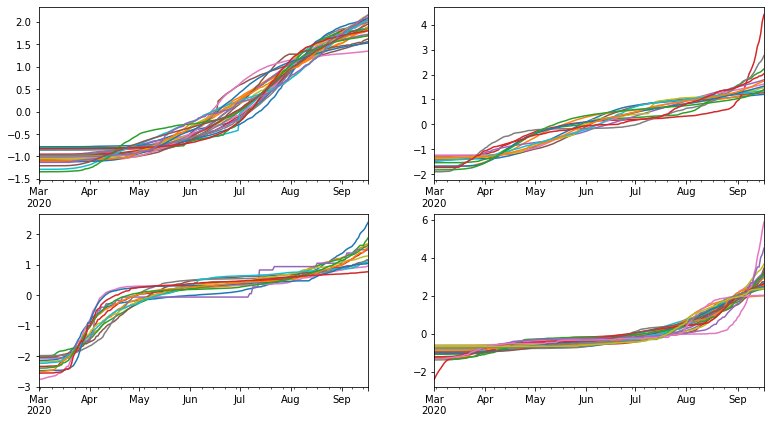

In [10]:
#Make a figure with the four clusters
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_gmm_z_0.plot(legend='', ax=axes[0,0])
df_gmm_z_1.plot(legend='', ax=axes[0,1])
df_gmm_z_2.plot(legend='', ax=axes[1,0])
df_gmm_z_3.plot(legend='', ax=axes[1,1])

## Selecting test countries

In [11]:
df_forecasting = pd.read_parquet('../../data/forecasting_format/dataframe_forecasting_with_features.parquet')

In [12]:
Algeria_df = df_forecasting [df_forecasting['Country'].isin(['Algeria'])]

In [13]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [14]:
Belgium_df = df_forecasting[df_forecasting['Country'].isin(['Belgium'])]

In [15]:
test_2_df =  Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [16]:
Bangladesh_df = df_forecasting[df_forecasting['Country'].isin(['Bangladesh'])]

In [17]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [18]:
Croatia_df = df_forecasting[df_forecasting['Country'].isin(['Croatia'])]

In [19]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [20]:
selected_clusters = []
test_countries_not_used = []

In [21]:
def forecasting(gmm_countries_list,gmm_df,country_df,test_df):
    gmm_df = df_forecasting[df_forecasting['Country'].isin(gmm_countries_list)]
    gmm_training_df = gmm_df[(gmm_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (gmm_df.index.date <= datetime.date(2020, 9, 9))].copy()
    feature_list = ['Country','Month','Day','prev_case']
    params= {'iterations': 5000, 'silent': True}
    model = CatBoostRegressor(**params)
    gmm_CB_df = predict(model=model, training_df=gmm_training_df.copy(), 
                                                             test_df=test_df.copy(),
                                                             feature_list=feature_list)
    gmm_CB_df = accumulated_dataframe_column(country_df,gmm_CB_df)
    return gmm_CB_df

## Forecasting, cluster with Algeria

Select correct cluster

In [22]:
if 'Algeria' in df_gmm_z_0.columns and 'df_gmm_z_0' not in selected_clusters:
    gmm_1_df = df_gmm_z_0.copy()
    selected_clusters.append('df_gmm_z_0')
elif 'Algeria' in df_gmm_z_1.columns and 'df_gmm_z_1' not in selected_clusters:
    gmm_1_df = df_gmm_z_1.copy()
    selected_clusters.append('df_gmm_z_1')
elif 'Algeria' in df_gmm_z_2.columns and 'df_gmm_z_2' not in selected_clusters:
    gmm_1_df = df_gmm_z_2.copy()
    selected_clusters.append('df_gmm_z_2')
elif 'Algeria' in df_gmm_z_3.columns and 'df_gmm_z_3' not in selected_clusters:
    gmm_1_df = df_gmm_z_3.copy()
    selected_clusters.append('df_gmm_z_3')
else:
    test_countries_not_used.append('Algeria')

In [23]:
print(selected_clusters)
print(test_countries_not_used)

['df_gmm_z_0']
[]


In [24]:
if 'Algeria' not in test_countries_not_used:
    gmm_1_countries_list = list(gmm_1_df.columns)
    gmm_1_CB_df = forecasting(gmm_1_countries_list,gmm_1_df,Algeria_df,test_1_df)

In [25]:
print(gmm_1_countries_list)

['Algeria', 'Bahrain', 'Bangladesh', 'Bolivia', 'Bulgaria', 'Chile', 'Dominican Republic', 'El Salvador', 'Ghana', 'Kazakhstan', 'Kenya', 'Kuwait', 'Malawi', 'Mexico', 'Nigeria', 'Oman', 'Pakistan', 'Panama', 'Peru', 'Poland', 'Saudi Arabia', 'Senegal', 'Serbia', 'South Africa', 'Togo', 'United States']


In [26]:
print(len(gmm_1_countries_list))

26


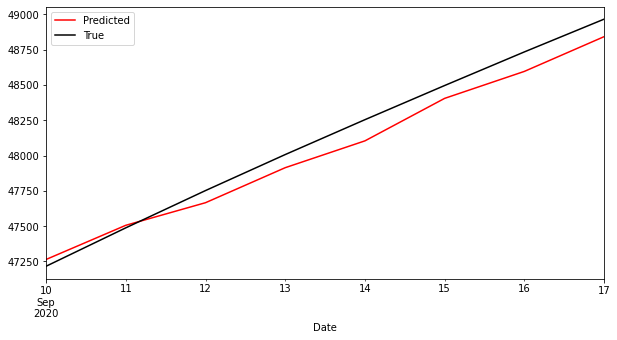

In [27]:
gmm_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE gmm 1:

In [28]:
round(SMAPE(gmm_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.1937

## Cluster with Belgium

Select correct cluster

In [29]:
if 'Belgium' in df_gmm_z_0.columns and 'df_gmm_z_0' not in selected_clusters:
    gmm_2_df = df_gmm_z_0.copy()
    selected_clusters.append('df_gmm_z_0')
elif 'Belgium' in df_gmm_z_1.columns and 'df_gmm_z_1' not in selected_clusters:
    gmm_2_df = df_gmm_z_1.copy()
    selected_clusters.append('df_gmm_z_1')
elif 'Belgium' in df_gmm_z_2.columns and 'df_gmm_z_2' not in selected_clusters:
    gmm_2_df = df_gmm_z_2.copy()
    selected_clusters.append('df_gmm_z_2')
elif 'Belgium' in df_gmm_z_3.columns and 'df_gmm_z_3' not in selected_clusters:
    gmm_2_df = df_gmm_z_3.copy()
    selected_clusters.append('df_gmm_z_3')
else:
    test_countries_not_used.append('Belgium')

In [30]:
print(selected_clusters)
print(test_countries_not_used)

['df_gmm_z_0', 'df_gmm_z_2']
[]


In [31]:
if 'Belgium' not in test_countries_not_used:
    gmm_2_countries_list = list(gmm_2_df.columns)
    gmm_2_CB_df = forecasting(gmm_2_countries_list,gmm_2_df,Belgium_df,test_2_df)

In [32]:
print(gmm_2_countries_list)

['Austria', 'Belgium', 'Denmark', 'Estonia', 'Fiji', 'Finland', 'Iceland', 'Ireland', 'Latvia', 'Malaysia', 'New Zealand', 'Norway', 'Switzerland', 'Thailand']


In [33]:
print(len(gmm_2_countries_list))

14


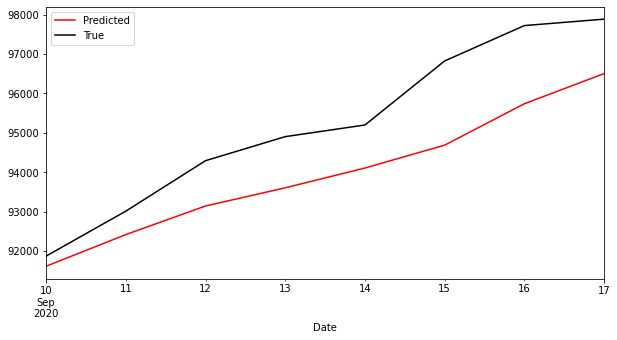

In [34]:
gmm_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE gmm 2:

In [35]:
round(SMAPE(gmm_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

1.2981

## Cluster with Bangladesh

Select correct cluster

In [36]:
if 'Bangladesh' in df_gmm_z_0.columns and 'df_gmm_z_0' not in selected_clusters:
    gmm_3_df = df_gmm_z_0.copy()
    selected_clusters.append('df_gmm_z_0')
elif 'Bangladesh' in df_gmm_z_1.columns and 'df_gmm_z_1' not in selected_clusters:
    gmm_3_df = df_gmm_z_1.copy()
    selected_clusters.append('df_gmm_z_1')
elif 'Bangladesh' in df_gmm_z_2.columns and 'df_gmm_z_2' not in selected_clusters:
    gmm_3_df = df_gmm_z_2.copy()
    selected_clusters.append('df_gmm_z_2')
elif 'Bangladesh' in df_gmm_z_3.columns and 'df_gmm_z_3' not in selected_clusters:
    gmm_3_df = df_gmm_z_3.copy()
    selected_clusters.append('df_gmm_z_3')
else:
    test_countries_not_used.append('Bangladesh')

In [37]:
print(selected_clusters)
print(test_countries_not_used)

['df_gmm_z_0', 'df_gmm_z_2']
['Bangladesh']


In [38]:
if 'Bangladesh' not in test_countries_not_used:
    gmm_3_countries_list = list(gmm_3_df.columns)
    gmm_3_CB_df = forecasting(gmm_3_countries_list,gmm_3_df,Bangladesh_df,test_3_df)

In [39]:
print(gmm_3_countries_list)

NameError: name 'gmm_3_countries_list' is not defined

In [ ]:
print(len(gmm_3_countries_list))

In [ ]:
gmm_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE gmm 3:

In [ ]:
round(SMAPE(gmm_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

## Cluster with Croatia

Select correct cluster

In [40]:
if 'Croatia' in df_gmm_z_0.columns and 'df_gmm_z_0' not in selected_clusters:
    gmm_4_df = df_gmm_z_0.copy()
    selected_clusters.append('df_gmm_z_0')
elif 'Croatia' in df_gmm_z_1.columns  and 'df_gmm_z_1' not in selected_clusters:
    gmm_4_df = df_gmm_z_1.copy()
    selected_clusters.append('df_gmm_z_1')
elif 'Croatia' in df_gmm_z_2.columns and 'df_gmm_z_2' not in selected_clusters:
    gmm_4_df = df_gmm_z_2.copy()
    selected_clusters.append('df_gmm_z_2')
elif 'Croatia' in df_gmm_z_3.columns and 'df_gmm_z_3' not in selected_clusters:
    gmm_4_df = df_gmm_z_3.copy()
    selected_clusters.append('df_gmm_z_3')
else:
    test_countries_not_used.append('Croatia')

In [41]:
print(selected_clusters)
print(test_countries_not_used)

['df_gmm_z_0', 'df_gmm_z_2', 'df_gmm_z_3']
['Bangladesh']


In [42]:
if 'Croatia' not in test_countries_not_used:
    gmm_4_countries_list = list(gmm_4_df.columns)
    gmm_4_CB_df = forecasting(gmm_4_countries_list,gmm_4_df,Croatia_df,test_4_df)

In [43]:
print(gmm_4_countries_list)

['Argentina', 'Australia', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Ethiopia', 'Greece', 'India', 'Indonesia', 'Iraq', 'Israel', 'Japan', 'Malta', 'Morocco', 'Mozambique', 'Myanmar', 'Nepal', 'Paraguay', 'Philippines', 'Romania', 'Rwanda', 'Slovakia', 'South Korea', 'Tunisia', 'Ukraine', 'Vietnam', 'Zambia', 'Zimbabwe']


In [44]:
print(len(gmm_4_countries_list))

29


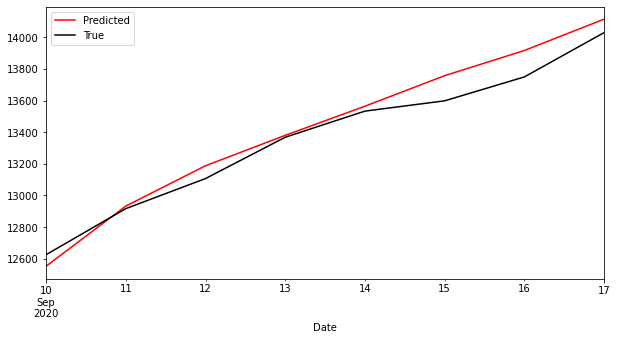

In [45]:
gmm_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE gmm 4:

In [46]:
round(SMAPE(gmm_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.5765

Total MAPE

In [47]:
round(SMAPE(gmm_1_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(SMAPE(gmm_2_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(SMAPE(gmm_3_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(SMAPE(gmm_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

NameError: name 'gmm_3_CB_df' is not defined